In [1]:
from IPython.display import display, HTML
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import torch
from flowtorch import bijectors, distributions

sns.set_theme()
sns.set_style("whitegrid")
sns.set_palette("muted")

display(HTML("<style>.container { width:70% !important; }</style>"))

# Overview of generative models

<center><img src="https://lilianweng.github.io/posts/2021-07-11-diffusion-models/generative-overview.png" alt="Illustration of generative models" width="80%"/></center>

# Normalizing Flows


Normalizing Flows (NFs) (Rezende & Mohamed, 2015) learn an invertible mapping from an (easy) latent/base/source distribution to a given data/target distribution.
<center><img src="https://gebob19.github.io/assets/norm_flow/nf.png" alt="Illustration of a normalizing flow" width="60%"/></center>

## Example from [`flowtorch`](https://flowtorch.ai)

We take the circles dataset as the target distribution $X$ which we want to learn.

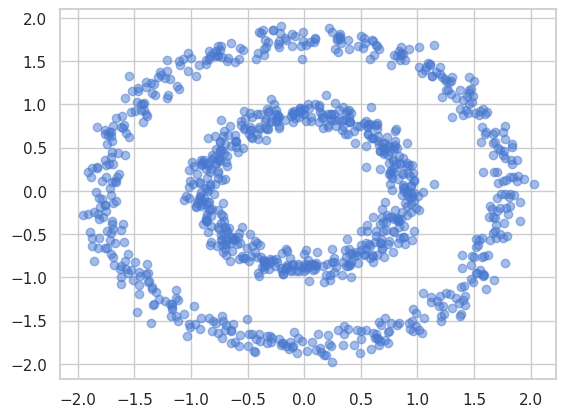

In [2]:
n_samples = 1000
target_data, _ = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
target_data = StandardScaler().fit_transform(target_data)

plt.scatter(target_data[:, 0], target_data[:, 1], alpha=0.5)
plt.show()

Let us take a standard normal as a latent distribution.

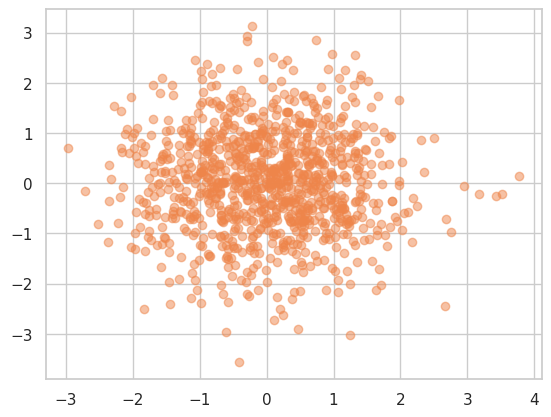

In [3]:
latent_dist = torch.distributions.Independent(
    torch.distributions.Normal(torch.zeros(2), torch.ones(2)), 1
)

n_samples_plt = torch.Size((1000,))
latent_data = latent_dist.sample(n_samples_plt).detach().numpy()
plt.scatter(
    latent_data[:, 0], latent_data[:, 1], color=sns.color_palette()[1], alpha=0.5
)
plt.show()

Now we map samples from the base distribution through a neural network and look at the output.

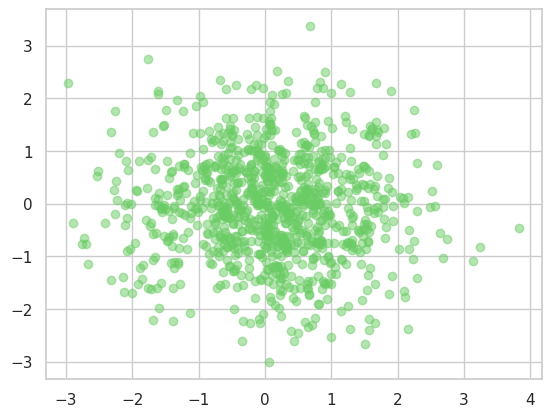

In [4]:
bijector = bijectors.SplineAutoregressive()
transformed_dist = distributions.Flow(latent_dist, bijector)

data = transformed_dist.sample(n_samples_plt).detach().numpy()
plt.scatter(data[:, 0], data[:, 1], color=sns.color_palette()[2], alpha=0.5)
plt.show()

Let us optimize the neural network by maximing the log-likelihood of the data samples.

In [5]:
dataset = torch.tensor(target_data, dtype=torch.float)
optimizer = torch.optim.Adam(transformed_dist.parameters(), lr=5e-3)
for step in range(2000):
    optimizer.zero_grad()
    loss = -transformed_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()

    if step % 500 == 0:
        print("step: {}, loss: {}".format(step, loss.item()))

step: 0, loss: 2.882357120513916
step: 500, loss: 1.8157120943069458
step: 1000, loss: 1.750326156616211
step: 1500, loss: 1.7973538637161255


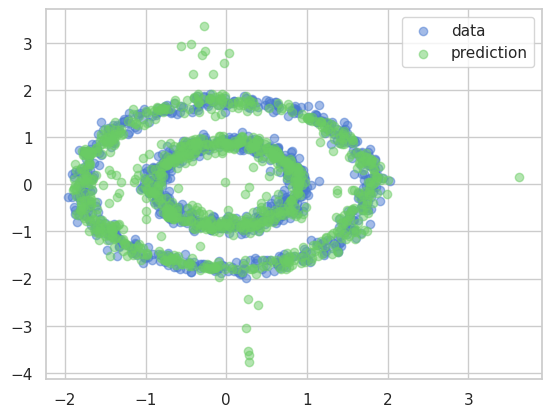

In [6]:
data = transformed_dist.sample(n_samples_plt).detach().numpy()
plt.scatter(target_data[:, 0], target_data[:, 1], alpha=0.5, label="data")
plt.scatter(
    data[:, 0], data[:, 1], color=sns.color_palette()[2], alpha=0.5, label="prediction"
)
plt.legend()
plt.show()

This looks pretty good!

But how did we compute the log-likelihood `transformed_dist.log_prob(dataset)`?


## Theoretical foundations

Let us start with a more formal definition:

- $X$ ... random variable (with density $ p_{X}$) describing the data distribution
- $Z$ ... random variable (with density $ p_{Z}$) describing the latent distribution


Normalizing flows deal with parametrized, measurable mappings $f_\theta$, which transform a base distribution $ p_{Z}$ into a target distribution $ p_{X}$. 

In other words, we seek a transformation $f_\theta$ such that the random variable

\begin{equation*}
    X_\theta := f_\theta(Z) \quad \text{(with density } p_{X_\theta})
\end{equation*}

satisfies $ p_{X_\theta} \approx p_{X}$.

**Question:** How can we compute the log-likelihood $\log p_{X_{\theta}}(X)$ of our data $X$ under our (parametrized) model $p_{X_{\theta}}$?

### Tool 1: Change of variables formula

For a diffeomorphism $f_\theta$ it holds that

\begin{equation*}
    p_{X_\theta} = \left( p_{Z} \circ f_\theta^{-1} \right) | \det (\nabla f_\theta^{-1})|.
\end{equation*}

This implies that

\begin{equation*}
\log p_{X_{\theta}}(X) =  \log \left( p_{Z} \circ f_\theta^{-1} \right)(X) + \log | \det (\nabla f_\theta^{-1}(X))|.
\end{equation*}

Choosing a tractable latent distribution $Z$ (such as a Gaussian), we can evaluate $p_Z$.

Thus, we seek mappings $f_\theta$ where we can (efficiently) compute the inverse $f_\theta^{-1}$ and the Jacobian determinant $\det (\nabla f_\theta^{-1})$.

### Tool 2: Closedness of diffeomorphisms under compositions

For diffeomorphisms $f^{(1)}$ and $f^{(2)}$ it holds that 

\begin{equation*}
    \left(f^{(2)}\circ f^{(1)}\right)^{-1} =  (f^{(1)})^{-1} \circ (f^{(2)})^{-1} 
\end{equation*}
and
\begin{equation*}
   \det\left(\nabla \left(f^{(2)}\circ f^{(1)}\right)\right) =  \det\left( \left(\nabla f^{(2)}\right) \circ f^{(1)}\right) \det\left(\nabla f^{(1)}\right).
\end{equation*}

Therefore, we can focus our attention on the construction of rather simple transformations $f_\theta^{(\ell)}$ which can then be composed, i.e.,

\begin{equation*}
    f_\theta = f^{(L)}_\theta \circ \dots \circ f^{(1)}_\theta.
\end{equation*}

E.g., the so-called *Glow* architecture has $L=320$ sub-transformations.

<center><img src="https://raw.githubusercontent.com/janosh/tikz/main/assets/normalizing-flow/normalizing-flow.svg" alt="Illustration" width="70%"/></center>

### Brief summary

- $f_\theta = f^{(L)}_\theta \circ \dots \circ f^{(1)}_\theta$
- each $f^{(\ell)}_\theta$ is a diffeomorphism with parameters $\theta$
- base distribution $Z$ is taken to be simple distribution (such as a multivariate Gaussian)

Normalizing flows allow us to

- **sample** from $p_{X_\theta}$ via
    $$X=f_\theta(Z)$$
given that we can sample from $p_{Z}$ and evaluate $f_\theta$.
- **evaluate the density** $p_{X_\theta}$ via
\begin{equation*}
    p_{X_\theta} = \left( p_{Z} \circ f_\theta^{-1} \right) | \det (\nabla f_\theta^{-1})|.
\end{equation*}
given that we can evaluate the density $p_{Z}$, evaluate the inverse $f_
\theta^{-1}$, and its Jacobian determinant $\det(\nabla f_
\theta^{-1})$.


The term **normalizing flow** refers to the trajectory through $(f_\theta^{(L)})^{-1}, \dots, (f_\theta^{(1)})^{-1}$ that a sample from $X_\theta = f_\theta(Z)$ follows as it is transformed (*normalized*) into a sample from the (simple) latent distribution $Z$.

### Remarks on the objective

1. **log-likelihood training/forward KL-divergence:**
    - needs data $(X^{(i)})_{i=1}^m$ and evaluation and differentiation of $f_\theta^{-1}$, its Jacobian determinant, and $p_{Z}$:
    
\begin{equation*}
    D_{\textrm{KL}}(X \parallel X_\theta) = \underbrace{\mathbb{E}\left[ \log\big(p_{X}(X)\big)\right]}_{\text{const.}} -\mathbb{E}\left[ \log\big(p_{Z}(f^{-1}_\theta(X))\big)\right] - \mathbb{E}\left[ \log \big| \det( \nabla f^{-1}_\theta(X))\big| \right].
\end{equation*}

2. **Reverse KL-divergence (sampling from unnormalized densities):**
    - needs data $(Z^{(i)})_{i=1}^m$ and evaluation and differentiation of $f_\theta$, its Jacobian determinant, and the unnormalized density $C \cdot p_{X}$:
    
    \begin{equation*}
        D_{\textrm{KL}}(X_\theta  \parallel X ) = \underbrace{\mathbb{E}\left[ \log p_{Z}(Z)\right]}_{\text{const.}} - \mathbb{E}\left[ \log\big| \det( \nabla f_\theta(Z))\big| \right]  - \mathbb{E}\left[ \log\big(C\cdot p_{X}(f_\theta(Z))\big)\right] + \underbrace{\log\big(C \big)}_{\text{const.}}.
    \end{equation*}

## Some architectures
(Of course) we parametrize $f^{(\ell)}_\theta$ as neural networks:

* Jacobian of $\nabla f^{(\ell)}_\theta$ can always be obtained by $d$ backward passes and its determinant can be computed with $\mathcal{O}(d^3)$ flops.

* We seek methods for which the complexity of computing the Jacobian determinant scales only linearly in the data dimension $d$. 

<center><img src="flow_overview.png" alt="Overview from [Papamakarios et al., 2021]" width="40%"/></center>

### Autoregressive Flows

1. Composed of functions of the form
    \begin{equation*}
        f_\theta(x) = \big(\tau_{c_i}(x_i)\big)_i \quad \text{with} \quad c_i = c^{(i)}_\theta(x_{i-1},\dots,x_1).
    \end{equation*}
2. The *conditioner* $c^{(i)}_\theta$ parametrizes the univariate *transformer* $\tau_{c}$.
3. For every $c$ the *transformer* $\tau_{c}$ is assumed to be monotonic and thus invertible.

<center><img src="https://tech.skit.ai/assets/images/posts/normalizing-flows/IAFs.png" alt="Illustration" width="70%"/></center>

$\Rightarrow$ represent the inverse and the Jacobian determinant as
\begin{equation*}
        f^{-1}_\theta(y) = \big(\tau^{-1}_{c_i}(y_i)\big)_i \quad \text{and} \quad \det(\nabla f_\theta(x)) = \prod_{i=1}^d \tau'_{c_i}(x_i).
        \end{equation*}

\begin{equation*}
        f_\theta(x) = \big(\tau_{c_i}(x_i)\big)_i \quad \text{with} \quad c_i = c^{(i)}_\theta(x_{i-1},\dots,x_1).
\end{equation*}

**Transformers $\tau_c$:** 
1. *affine functions* (limited expressivity)
2. compositions or conic combinations of *monotonic functions* (might need iterative methods to be inverted, e.g., bisection search)
3. *integrals of strictly positive functions* (need numerical approximation or special integrands, e.g. polynomials; typically not analytically invertible)
4. *splines* with parametrized knots (invertibility is guaranteed by invertibility of each piece where the index can be found efficiently by binary search)

<center><img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/coupling_flow.svg" alt="Illustration" width="30%"/></center>

\begin{equation*}
        f_\theta(x) = \big(\tau_{c_i}(x_i)\big)_i \quad \text{with} \quad c_i = c^{(i)}_\theta(x_{i-1},\dots,x_1).
\end{equation*}

**Conditioners $c_i$:** Efficient conditioners should share parameters across the $d$ conditioners $(c_\theta^{(i)})_{i=1}^d$ and viable options include:
   
1. *recurrent neural networks* (requires to compute $(c_i)_i$ iteratively)

2. *masked neural networks* where the index set $I=\{1,\dots,d\}$ is filtered into $K$ parts $I_1 \subset \dots \subset I_k=I$ and connections are masked such that the output $(c_i)_{i\in I_k \cap I_{k-1}}$ only depends on $(x_i)_{i\in I_{k-1}}$ 
    * outputs all $(c_i)_i$ at once
    * inverse flow needs $\mathcal{O}(K)$ forward passes until all coordinates of $x$ are known
    * $K$ trades off expressivity for efficiency ($K=d$ yields a fully auto-regressive structure, $K=2$ is called a coupling layer)
    * $(c^{(i)}_\theta)_{i\in I_1}$ sometimes chosen to be the identity.

<center><img src="https://tech.skit.ai/assets/images/posts/normalizing-flows/MADEs.png" alt="Illustration" width="50%"/></center>

### Linear Flows

Autoregressive flows depend on the order of the input coordinates (for masked NNs with $K<d$ not all coordinates interact with each other).

$\Rightarrow$ use permutations or, more general, invertible matrices as parts of the flow, i.e.,

\begin{equation*}
        f_\theta(x) := W_\theta x \quad \text{with} \quad W_\theta \in \mathbb{R}^{d\times d} \quad \text{and} \quad \det(W_\theta) \in \mathbb{R}\setminus \{0\}.
\end{equation*}

Naive implementations need $\mathcal{O}(d^3)$ flops to invert $W_\theta$ or compute $\det(W_\theta)$.

$\Rightarrow$ use structured families of matrices $(W_\theta)_\theta$, e.g. triangular matrices with its diagonal elements reparametrized by $e^{\theta_i}$ to guarantee positivity.

### Residual Flows
Building blocks of the form
\begin{equation*}
    f_\theta(x) := x + g_\theta(x),
\end{equation*}
where $g_\theta$ is based on:

1. Contractions
    - iterative inversion using the *Banach fixed-point theorem*.
    - estimate of the logarithm of the absolute Jacobian determinant using the Maclaurin series
    
    \begin{equation*}
        \log \left| \det(\nabla f_\theta) \right| = \sum_{k=1}^\infty \frac{(-1)^{k+1}}{k} \operatorname{tr}\left((\nabla g_\theta)^k\right) \approx \sum_{k=1}^\infty \frac{(-1)^{k+1}}{k} v^\top \left((\nabla g_\theta)^k\right) v,
    \end{equation*}
    
    where $v\in\mathbb{R}^d$ is a sample of a distribution with zero mean and covariance matrix $I_d$ (*Hutchinson trace estimator*). 

2. *Matrix determinant lemma:* 
    \begin{equation*}
        \det(\nabla f_\theta) = \det(A+VW^\top) = \det(I_d+W^\top A^{-1}V)\det(A)
    \end{equation*}

    * efficient Jacobian determinant
    * no analytical inverse $\Rightarrow$ mostly used to approximate posteriors 


## Universality

**One-dimensional case**: the *probability integral transform* and *inverse transform sampling* ensure that

\begin{equation*}
    F_X(X) \sim U \quad \text{and} \quad F_X^{-1}(U) \sim X, \quad \text{where} \quad U\sim \mathcal{U}([0,1]).
\end{equation*}

$F_X$ is the cumulative distribution function (CDF) and $F_X^{-1}$ its generalized inverse given by

\begin{equation*}
    F_X^{-1}(y) = \inf \{ x \colon F_X(x) \le y \}, \quad y\in (0,1).
\end{equation*}

$\Rightarrow$ $f_\theta:=F_X^{-1} \circ F_{Z}$ satisfies $  f_\theta(Z_\theta) \sim X$ yielding a suitable transformation.

**Multi-dimensional case:** Under suitable regularity conditions, a similar statement can be established by considering the CDFs of the conditionals, i.e.,

\begin{align}
    F^{(i)}_X(x_i, \dots, x_1) &= \mathbb{P}\left[X_i \le x_i | (X_{i-1}=x_{i-1}, \dots, X_1=x_1)\right] \\
    &=\int_{-\infty}^{x_i} p_{X_i | (X_{i-1}, \dots, X_1)}(\xi | x_{i-1}, \dots, x_1) \mathrm{d}\xi.
\end{align}

$\Rightarrow$ autoregressive flows are universal.

## Some comparsions 

... to diffusion models on Cifar and ImageNet:


<center><img src="results.png" alt="Results from https://arxiv.org/pdf/2107.00630.pdf" width="50%"/></center>

Apart from generation, interesting applications include: density estimation, auxiliary distributions for importance sampling, proposals for MCMC, approximation of posteriors, ...

## Final remarks on continuous-time normalizing flows

Viewing $\ell$ as discretization of a continuous time variable $t$, we can describe continuous-time flows using ODEs of the form
\begin{equation*}
    \frac{ \mathrm{d} Z^{(t)}_\theta}{\mathrm{d}t} = g_\theta (t, Z^{(t)}_\theta) \quad \text{with} \quad Z^{(0)}_\theta = Z.
\end{equation*}

The change in log density can also be described by an ODE, i.e.,

\begin{equation*}
     \frac{ \mathrm{d} \log \big( p_{Z^{(t)}_\theta} \big)}{\mathrm{d}t} = - \operatorname{tr} \left(\nabla g_\theta (t, \cdot) \right),
\end{equation*}

where the trace can be estimated using Hutchinson's trace estimator in a single backward pass.

- no other requirements to compute the change in density or to be invertible (i.e., running the ODE backwards).
- all intermediate spaces need to be homeomorphic $\Rightarrow$ topological constraints.